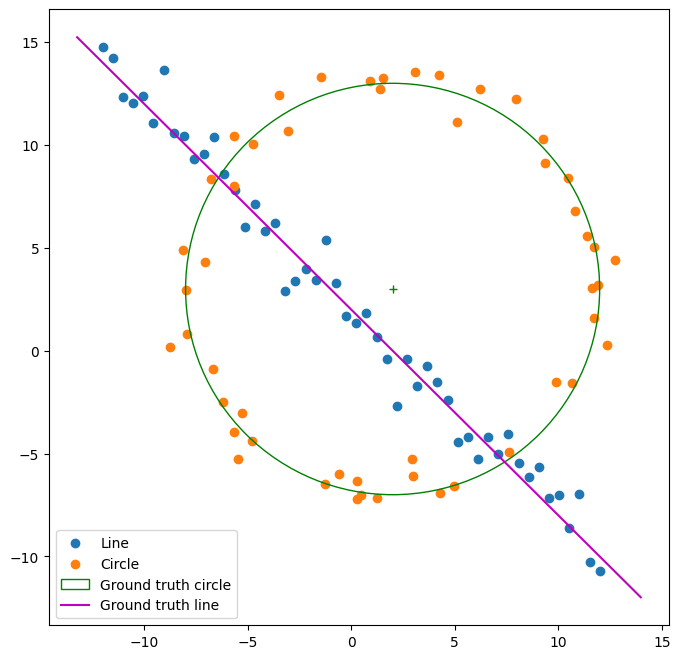

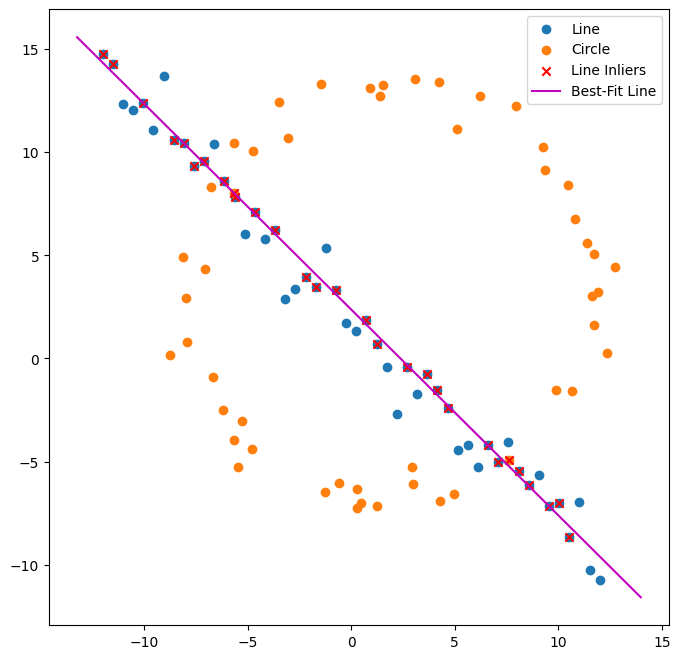

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
# np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()
plt.show()




# Define the RANSAC parameters
num_iterations = 100  # Number of RANSAC iterations
min_samples = 2  # Minimum number of points to fit a line
error_threshold = 0.5  # Threshold for considering a point as an inlier

best_line = None
best_line_inliers = []
best_line_residual = np.inf

# Implement RANSAC for line fitting
for _ in range(num_iterations):
    # Randomly sample two points from X
    sample_indices = np.random.choice(X.shape[0], min_samples, replace=False)
    sample = X[sample_indices]

    # Fit a line to the sampled points
    A = np.vstack([sample[:, 0], np.ones(min_samples)]).T
    a, b = np.linalg.lstsq(A, sample[:, 1], rcond=None)[0]

    # Calculate the distance from all points to the line
    distances = np.abs(a * X[:, 0] - X[:, 1] + b) / np.sqrt(a**2 + 1)

    # Count inliers
    inliers = X[distances < error_threshold]
    if len(inliers) > len(best_line_inliers):
        best_line = (a, b)
        best_line_inliers = inliers
        best_line_residual = np.sum(distances)

# Plot the best-fit line and inliers
plt.figure(figsize=(8, 8))
plt.scatter(X_line[:, 0], X_line[:, 1], label='Line')
plt.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
plt.scatter(best_line_inliers[:, 0], best_line_inliers[:, 1], c='r', marker='x', label='Line Inliers')
x_min, x_max = plt.xlim()
x_range = np.array([x_min, x_max])
y_range = best_line[0] * x_range + best_line[1]
plt.plot(x_range, y_range, color='m', label='Best-Fit Line')
plt.legend()
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_14936\489202097.py:44: RuntimeWarning: invalid value encountered in sqrt
  y_range = np.sqrt(best_circle[2]**2 - (x_range - best_circle[0])**2) + best_circle[1]


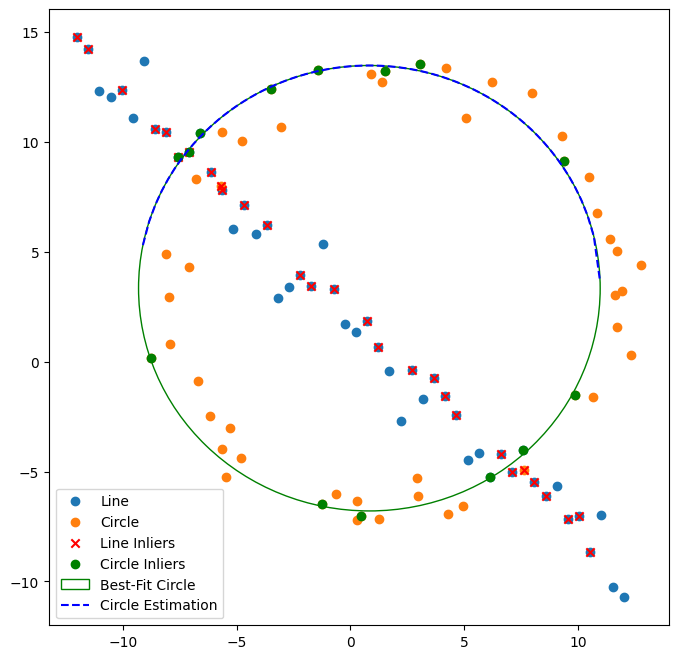

In [5]:
# Subtract line inliers to obtain the remnant
remnant = X[np.logical_not(np.isin(X, best_line_inliers).all(axis=1))]

# Define RANSAC parameters for circle fitting
num_iterations_circle = 100
min_samples_circle = 3
error_threshold_circle = .3  # Adjust this threshold as needed

best_circle = None
best_circle_inliers = []
best_circle_residual = np.inf

# Implement RANSAC for circle fitting on the remnant
for _ in range(num_iterations_circle):
    # Randomly sample three points from the remnant
    sample_indices_circle = np.random.choice(remnant.shape[0], min_samples_circle, replace=False)
    sample_circle = remnant[sample_indices_circle]

    # Fit a circle to the sampled points
    x_circle, y_circle = sample_circle[:, 0], sample_circle[:, 1]
    x0, y0 = np.mean(x_circle), np.mean(y_circle)
    r = np.mean(np.sqrt((x_circle - x0)**2 + (y_circle - y0)**2))

    # Calculate the radial distance from all points to the circle
    distances_circle = np.abs(np.sqrt((X[:, 0] - x0)**2 + (X[:, 1] - y0)**2) - r)

    # Count inliers
    inliers_circle = X[distances_circle < error_threshold_circle]
    if len(inliers_circle) > len(best_circle_inliers):
        best_circle = (x0, y0, r)
        best_circle_inliers = inliers_circle
        best_circle_residual = np.sum(distances_circle)

# Plot the best-fit circle and inliers
plt.figure(figsize=(8, 8))
plt.scatter(X_line[:, 0], X_line[:, 1], label='Line')
plt.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
plt.scatter(best_line_inliers[:, 0], best_line_inliers[:, 1], c='r', marker='x', label='Line Inliers')
plt.scatter(best_circle_inliers[:, 0], best_circle_inliers[:, 1], c='g', marker='o', label='Circle Inliers')
circle = plt.Circle((best_circle[0], best_circle[1]), best_circle[2], color='g', fill=False, label='Best-Fit Circle')
plt.gca().add_patch(circle)
x_min, x_max = plt.xlim()
x_range = np.linspace(x_min, x_max, 100)
y_range = np.sqrt(best_circle[2]**2 - (x_range - best_circle[0])**2) + best_circle[1]
plt.plot(x_range, y_range, color='b', linestyle='--', label='Circle Estimation')
plt.legend()
plt.show()
